# Forecast Consumption

Forecasting using timeseries model the consumption of water, gas and electricity.

https://www.tensorflow.org/tutorials/structured_data/time_series#setup



In [47]:
# from pathlib import Path
# import sys
# import pandas as pd

# sys.path.append(str(Path.cwd().parents[0]))
# from core.data_manager import read_data_csv_df


# # function to read the data
# def read_data_csv_df(directory: str, filename: str) -> pd.DataFrame:
#     path=Path.cwd().parents[0]
#     try:
#         df = pd.read_csv(path.joinpath(directory,filename))
#         return df
#     except FileNotFoundError:
#         print(f"File {filename} not found")
#         print("Please verify the file name and try again, and path")
#         exit()

# df = read_data_csv_df("data_storage", "resampled_data_D_gas.csv")


# "data_storage", "resampled_data_D_gas.csv"

# df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_gas.csv"))
# df.columns
# print(df.columns)

## Preparing the data

In [1]:
# Import the necessary libraries
import pandas as pd
from os import path
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# sys.path.append('../../')
# from core.settings import gas_monthly_df

In [2]:
# variables


path = Path.cwd().parents[0]


# gas_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_gas.csv"))
# water_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_water.csv"))
power_daily_df = pd.read_csv(
    path.joinpath("data_storage", "resampled_data_D_power.csv")
)

In [3]:
# gas_daily_df.info()
# # gas_monthly_df.describe()

power_daily_df.info()
# power_monthly_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       4837 non-null   object 
 1   id_meter   4837 non-null   float64
 2   power_kwh  4837 non-null   float64
 3   calc_cons  4834 non-null   float64
dtypes: float64(3), object(1)
memory usage: 151.3+ KB


In [4]:
# show duplicate dates in the data
power_daily_df[power_daily_df.duplicated(subset=["date"], keep=False)]

,date,id_meter,power_kwh,calc_cons
0,2014-09-04,4.0,51419.300000,NaN
1,2014-09-05,4.0,51422.141748,2.841748
2,2014-09-06,4.0,51424.983495,2.841748
3,2014-09-07,4.0,51427.825243,2.841748
4,2014-09-08,4.0,51430.666990,2.841748
...,...,...,...,...
4832,2014-11-24,7.0,2232.200000,0.000000
4833,2014-11-25,7.0,2232.200000,0.000000
4834,2014-11-26,7.0,2232.200000,0.000000
4835,2014-11-27,7.0,2232.200000,0.000000


In [5]:
# sort by date
power_daily_df.sort_values(by=["date"], inplace=True)
# show date 2021-04-01
power_daily_df[power_daily_df["date"] < "2021-04-03"]

,date,id_meter,power_kwh,calc_cons
3560,2011-06-01,7.0,0.000000,NaN
3561,2011-06-02,7.0,1.831173,1.831173
3562,2011-06-03,7.0,3.662346,1.831173
3563,2011-06-04,7.0,5.493519,1.831173
3564,2011-06-05,7.0,7.324692,1.831173
...,...,...,...,...
2399,2021-03-29,5.0,94.914286,3.328571
2400,2021-03-30,5.0,98.242857,3.328571
2401,2021-03-31,5.0,101.571429,3.328571
2402,2021-04-01,5.0,104.900000,3.328571


In [6]:
print(power_daily_df.head())
# Dealing with missing values
# # show NaN values rows
# gas_monthly_df[gas_monthly_df.isnull().any(axis=1)]

# # show duplicate rows
# gas_monthly_df[gas_monthly_df.duplicated()]

# # show rows for date 2014-09-04
# gas_monthly_df[gas_monthly_df['date'] == '2014-09-04']

# agregate by id_meter, date
power_daily_df = power_daily_df.groupby(["id_meter", "date"]).agg("sum").reset_index()

# agregate by date, if id_meter is the same, sum the values, else keep both values
power_daily_df = (
    power_daily_df.groupby(["date"])
    .agg(
        {
            "calc_cons": "sum",
            "id_meter": lambda x: ", ".join(map(str, x)),
        }
    )
    .reset_index()
)

# in the column id_meter, keep only one value
power_daily_df["id_meter"] = power_daily_df["id_meter"].apply(lambda x: x.split(",")[0])

# convert id_meter to float
power_daily_df["id_meter"] = power_daily_df["id_meter"].astype(float)

# # in the column id_meter, keep only the value that is last in the list
# power_daily_df["id_meter"] = power_daily_df["id_meter"].apply(
#     lambda x: x.split(",")[-1]
# )
# # remove empty spaces in the column id_meter
# power_daily_df["id_meter"] = power_daily_df["id_meter"].str.strip()

# fill row 0 NaN value with 0
power_daily_df = power_daily_df.fillna(0, inplace=False)

# drop duplicate rows keeping the last row
power_daily_df.drop_duplicates(subset=["date"], keep="last", inplace=True)

# # show duplicate dates rows
# gas_monthly_df[gas_monthly_df.duplicated(['date'])]

# # # drop duplicate dates rows
# # gas_monthly_df.drop_duplicates(subset=['date'], inplace=False)

# convert date column to datetime
power_daily_df["date"] = pd.to_datetime(power_daily_df["date"])


power_daily_df.info()

# # verify that there are not missing dates in the data
# gas_monthly_df['date'] = pd.to_datetime(gas_monthly_df['date'])
# gas_monthly_df['date'].diff().dt.days

            date  id_meter  power_kwh  calc_cons
3560  2011-06-01       7.0   0.000000        NaN
3561  2011-06-02       7.0   1.831173   1.831173
3562  2011-06-03       7.0   3.662346   1.831173
3563  2011-06-04       7.0   5.493519   1.831173
3564  2011-06-05       7.0   7.324692   1.831173
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4750 non-null   datetime64[ns]
 1   calc_cons  4750 non-null   float64       
 2   id_meter   4750 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 111.5 KB


In [7]:
# drop columns not columns 1 to 3
# gas_daily_df = gas_daily_df.drop(gas_daily_df.columns[1:3], axis=1, inplace=False)

power_daily_df.head()

# unique values in id_meter column
power_daily_df["id_meter"].unique()

# # show values with id_meter == 11
# power_daily_df[power_daily_df['id_meter'] == 11]

array([7., 4., 5.])

In [8]:
# show 0 values in calc_cons column
power_daily_df[power_daily_df["calc_cons"] == 0]

,date,calc_cons,id_meter
0,2011-06-01,0.0,7.0


In [9]:
# show duplicate dates rows
power_daily_df[power_daily_df.duplicated(["date"])]

,date,calc_cons,id_meter


In [57]:
# # convert date column to datetime
# power_daily_df["date"] = pd.to_datetime(power_daily_df["date"])
# # set date column as index
# power_daily_df.set_index("date", inplace=True)

In [10]:
# sort by date
power_daily_df = power_daily_df.sort_values(by="date")

In [11]:
power_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4750 non-null   datetime64[ns]
 1   calc_cons  4750 non-null   float64       
 2   id_meter   4750 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 111.5 KB


In [12]:
power_daily_df.describe()

,date,calc_cons,id_meter
count,4750,4750.000000,4750.000000
mean,2017-11-30 12:00:00,2.490211,5.001684
min,2011-06-01 00:00:00,0.000000,4.000000
25%,2014-08-31 06:00:00,1.831173,4.000000
50%,2017-11-30 12:00:00,2.461429,5.000000
75%,2021-03-01 18:00:00,3.122581,7.000000
max,2024-06-01 00:00:00,4.672921,7.000000
std,NaN,0.927730,1.225990


## Prepare the model

In [61]:
# # subsample the data to hourly
# gas_hourly_df = gas_daily_df.resample('h').mean()

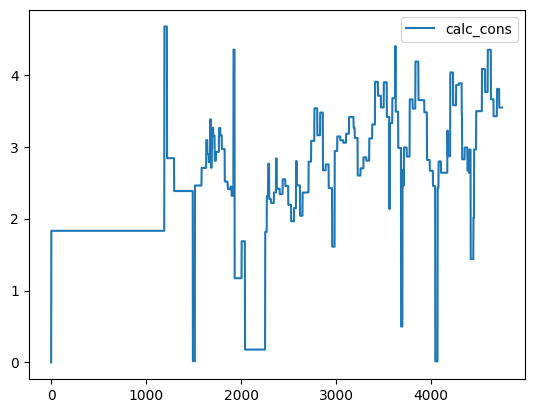

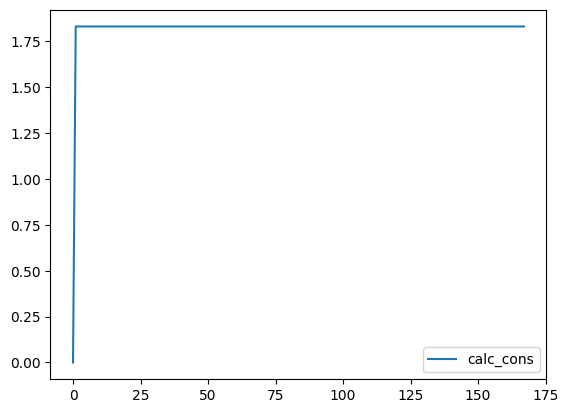

In [14]:
# list with the column defined by position 1, 2 in the axis 1
plot_cols = power_daily_df.columns[1:2]
plot_features = power_daily_df[plot_cols]
plot_features.index = power_daily_df.index
_ = plot_features.plot(subplots=True)

plot_features = power_daily_df[plot_cols][:168]
plot_features.index = power_daily_df.index[:168]
_ = plot_features.plot(subplots=True)

## Featured Engineering

In [15]:
# convert time
# convert date to seconds to made it more readable
power_daily_df["date"] = pd.to_datetime(power_daily_df["date"])

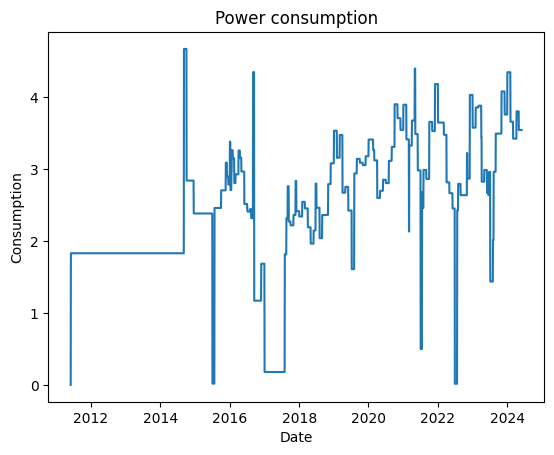

In [16]:
# assuming daily, weekly, monthly, yearly perioditicity
# daily
power_daily_df["day"] = power_daily_df["date"].dt.day
power_daily_df["month"] = power_daily_df["date"].dt.month
power_daily_df["year"] = power_daily_df["date"].dt.year
power_daily_df["dayofweek"] = power_daily_df["date"].dt.dayofweek
power_daily_df["dayofyear"] = power_daily_df["date"].dt.dayofyear
# power_daily_df["week"] = power_daily_df["date"].dt.week
power_daily_df["quarter"] = power_daily_df["date"].dt.quarter

# # weekly
# power_daily_df["week"] = power_daily_df["date"].dt.week

# monthly
power_daily_df["month"] = power_daily_df["date"].dt.month

# yearly
power_daily_df["year"] = power_daily_df["date"].dt.year

# show the first rows
power_daily_df.head()

# plot the data
plt.plot(np.array(power_daily_df["date"]), np.array(power_daily_df["calc_cons"]))
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Power consumption")
plt.show()

# plt.plot(np.array(power_daily_df["day"]), np.array(power_daily_df["calc_cons"]))
# plt.xlabel("Day")
# plt.ylabel("Consumption")
# plt.title("Power consumption")
# plt.show()

Text(0.5, 1.0, 'Time of day signal')

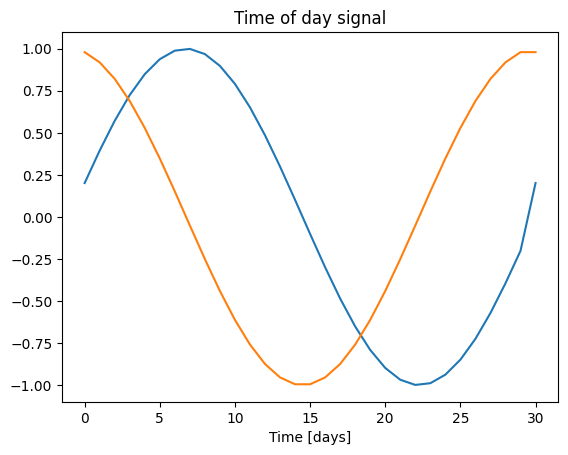

In [17]:
# using cosine and sine to encode the cyclical nature of time
# day
power_daily_df["day_sin"] = np.sin(power_daily_df["day"] * (2 * np.pi / 31))
power_daily_df["day_cos"] = np.cos(power_daily_df["day"] * (2 * np.pi / 31))
# month
power_daily_df["month_sin"] = np.sin(power_daily_df["month"] * (2 * np.pi / 12))
power_daily_df["month_cos"] = np.cos(power_daily_df["month"] * (2 * np.pi / 12))
# year
power_daily_df["year_sin"] = np.sin(power_daily_df["year"] * (2 * np.pi / 2021))
power_daily_df["year_cos"] = np.cos(power_daily_df["year"] * (2 * np.pi / 2021))
# dayofweek
power_daily_df["dayofweek_sin"] = np.sin(power_daily_df["dayofweek"] * (2 * np.pi / 7))
power_daily_df["dayofweek_cos"] = np.cos(power_daily_df["dayofweek"] * (2 * np.pi / 7))
# dayofyear
power_daily_df["dayofyear_sin"] = np.sin(
    power_daily_df["dayofyear"] * (2 * np.pi / 366)
)
power_daily_df["dayofyear_cos"] = np.cos(
    power_daily_df["dayofyear"] * (2 * np.pi / 366)
)
# quarter
power_daily_df["quarter_sin"] = np.sin(power_daily_df["quarter"] * (2 * np.pi / 4))
power_daily_df["quarter_cos"] = np.cos(power_daily_df["quarter"] * (2 * np.pi / 4))

# # show the first rows
power_daily_df.head()

plt.plot(np.array(power_daily_df["day_sin"])[:31])
plt.plot(np.array(power_daily_df["day_cos"])[:31])
plt.xlabel("Time [days]")
plt.title("Time of day signal")

Fast Fourier Transform???

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you don't have that information, you can determine which frequencies are important by extracting features with Fast Fourier Transform. To check the assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:


```python
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
```

In [18]:
# Split the data
# split the data into train, validation, and test set
# train set is 70% of the data
# validation set is 15% of the data
# test set is 15% of the data
"""
You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:
It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.
"""
n = len(power_daily_df)
train_df = power_daily_df[0 : int(n * 0.7)]
val_df = power_daily_df[int(n * 0.7) : int(n * 0.85)]
test_df = power_daily_df[int(n * 0.85) :]
# check the length of the data
print(len(train_df), len(val_df), len(test_df))

num_features = power_daily_df.shape[1]

print(f"Number of features = {num_features}")

3325 712 713
Number of features = 21


A Large Comparison of Normalization Methods on Time Series
https://www.sciencedirect.com/science/article/abs/pii/S2214579623000400
https://link.springer.com/chapter/10.1007/978-3-031-11432-8_8
Normalization is a mandatory preprocessing step in time series problems to guarantee similarity comparisons invariant to unexpected distortions in amplitude and offset. Such distortions are usual for most time series data. 

In [19]:
# Normalize the data
# normalize the data using the mean and standard deviation of the training data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# # show the first rows
train_df.head()

C:\Users\zudel\AppData\Local\Temp\ipykernel_31580\1963666855.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_df = (train_df - train_mean) / train_std
C:\Users\zudel\AppData\Local\Temp\ipykernel_31580\1963666855.py:7: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val_df = (val_df - train_mean) / train_std
C:\Users\zudel\AppData\Local\Temp\ipykernel_31580\1963666855.py:8: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_df = (test_df - train_mean) / train_std


,date,calc_cons,id_meter,day,month,year,dayofweek,dayofyear,quarter,day_sin,...,month_sin,month_cos,year_sin,year_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,quarter_sin,quarter_cos
0,-1.73127,-2.714939,1.338369,-1.669404,-0.151047,-1.679387,-0.499925,-0.295327,-0.453672,0.278432,...,0.007956,-1.386756,-1.679238,-2.067633,1.378549,-0.314645,0.716826,-1.195648,0.009397,-1.399038
1,-1.730228,-0.423943,1.338369,-1.555884,-0.151047,-1.679387,0.0,-0.285791,-0.453672,0.549041,...,0.007956,-1.386756,-1.679238,-2.067633,0.613512,-1.273971,0.695724,-1.207742,0.009397,-1.399038
2,-1.729186,-0.423943,1.338369,-1.442365,-0.151047,-1.679387,0.499925,-0.276254,-0.453672,0.797019,...,0.007956,-1.386756,-1.679238,-2.067633,-0.613512,-1.273971,0.674416,-1.219474,0.009397,-1.399038
3,-1.728145,-0.423943,1.338369,-1.328845,-0.151047,-1.679387,0.99985,-0.266717,-0.453672,1.012215,...,0.007956,-1.386756,-1.679238,-2.067633,-1.378549,-0.314645,0.652908,-1.230841,0.009397,-1.399038
4,-1.727103,-0.423943,1.338369,-1.215326,-0.151047,-1.679387,1.499774,-0.25718,-0.453672,1.185818,...,0.007956,-1.386756,-1.679238,-2.067633,-1.10551,0.881615,0.631206,-1.24184,0.009397,-1.399038


/tmp/ipykernel_7179/464633000.py:1: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_std = (power_daily_df - train_mean) / train_std
/tmp/ipykernel_7179/464633000.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(power_daily_df.keys(), rotation=90)


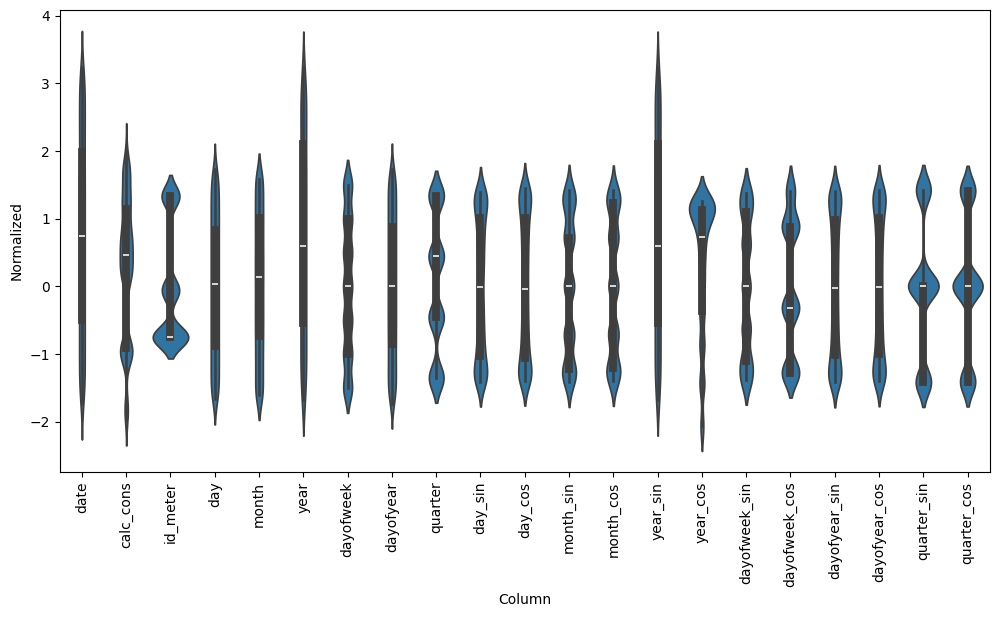

In [70]:
df_std = (power_daily_df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(power_daily_df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- Single-output, and multi-output predictions.
- Single-time-step and multi-time-step predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

The rest of this section defines a WindowGenerator class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
2. Split windows of features into (features, labels) pairs.
3. Plot the content of the resulting windows.
4. Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.


In [71]:
# Indexes and offsets
"""
Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.
It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.
"""


class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

In [72]:
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=["calc_cons"]
)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['calc_cons']

In [73]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["calc_cons"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['calc_cons']

In [74]:
# Split into windows
"""
The WindowGenerator object can split the DataFrame into these sequences. The __init__ and split_window methods are for this purpose.
The split_window method will convert a single DataFrame into a window of inputs and a window of labels.
The example WindowGenerator w2 will be used to demonstrate the split.
"""


def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes manually.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [75]:
WindowGenerator.split_window = split_window

In [76]:
# Stack three slices, the length of the total window:
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 7, 21)
Inputs shape: (3, 6, 21)
labels shape: (3, 1, 1)


In [77]:
# Plot
w2.example = example_inputs, example_labels

In [78]:
def plot(self, model=None, plot_col="calc_cons", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot

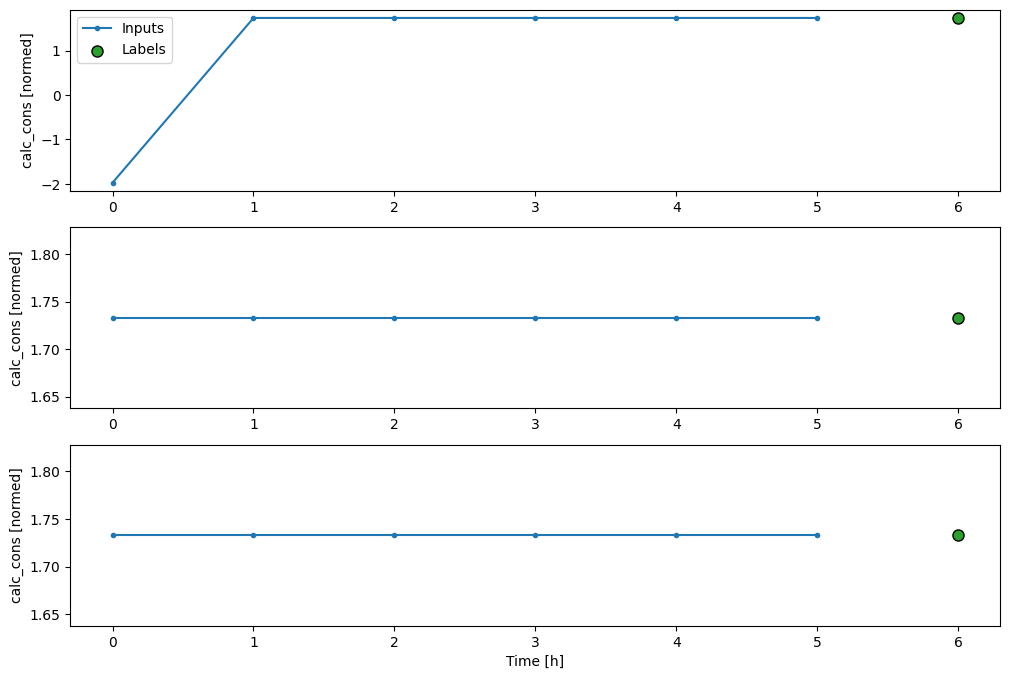

In [79]:
w2.plot()

In [80]:
# create tf.data.Dataset
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset

In [81]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [82]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 21), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [83]:
# iterate over the dataset
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 21)
Labels shape (batch, time, features): (32, 1, 1)


2024-06-22 13:26:02.375245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [84]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["calc_cons"]
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['calc_cons']

In [85]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 21)
Labels shape (batch, time, features): (32, 1, 1)


2024-06-22 13:26:02.562530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Baseline

In [86]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [87]:
# instantiate and evaluate the baseline model
baseline = Baseline(label_index=column_indices["calc_cons"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val, return_dict=True)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337 - mean_absolute_error: 0.0238          


In [88]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["calc_cons"]
)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['calc_cons']

In [89]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 21)
Output shape: (32, 24, 1)


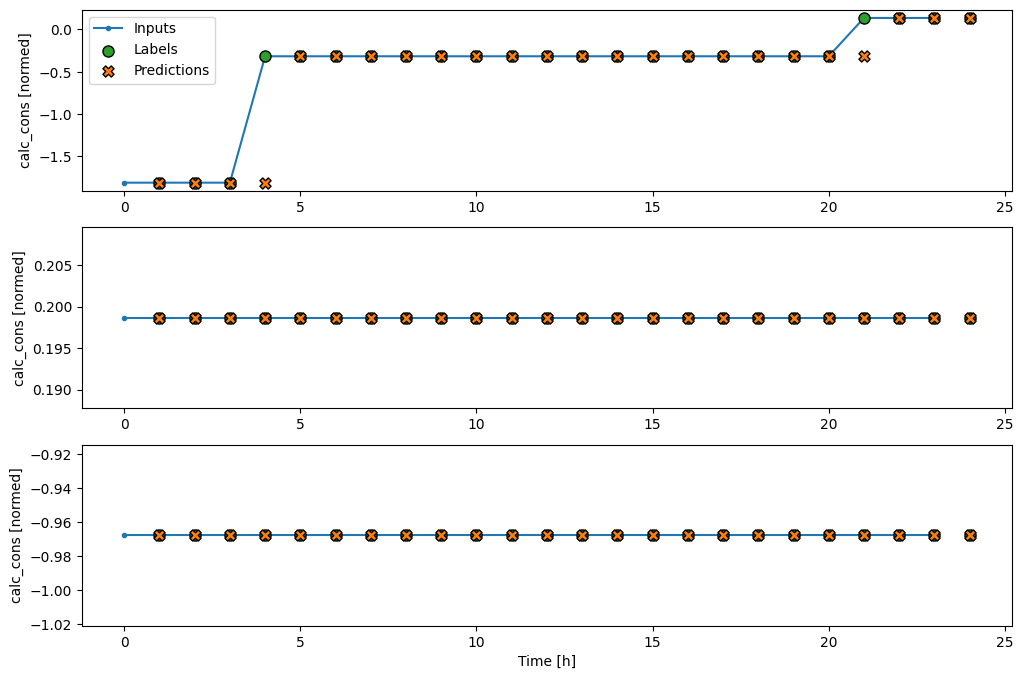

In [90]:
wide_window.plot(baseline)

In [91]:
linear = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=1),
    ]
)

In [92]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 21)
Output shape: (32, 1, 1)


In [ ]:
from tkinter.tix import MAX


MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history